In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Proyecto Montecarlo
Por: Alexander Valencia, Daniel Henao

In [3]:
!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libxext-dev is already the newest version (2:1.3.3-1).
libxext-dev set to manually installed.
libxft-dev is already the newest version (2.3.2-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
dpkg-dev is already the newest version (1.19.0.5ubuntu2.3).
dpkg-dev set to manually installed.
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
gcc set to manually installed.
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
git is already the newest version (1:2.17.1-1ubuntu0.7).
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
libx11-dev set to manually installed.
tar is already the newest version (1.29b-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following add

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!tar -xf /content/drive/Shared\ drives/PyROOT_in_Google/root_build_google_yikes.tar

In [6]:
import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")

In [7]:
import ROOT

Welcome to JupyROOT 6.14/04


##Datos Daniel Henao

In [8]:
# Se carga el archivo ROOT de Daniel Henao

DataChain = ROOT.TChain("SystemTree")
DataChain.Add("/content/drive/My Drive/fiscomp/DanielAndresHenao.root") # Cambiar ruta de archivo

1

In [9]:
NumberOfEventsToCheck=DataChain.GetEntries()
print("We are going to analyze ",NumberOfEventsToCheck, " events")

We are going to analyze  85000  events


 FCN=155.268 FROM MIGRAD    STATUS=CONVERGED     200 CALLS         201 TOTAL
                     EDM=1.81846e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.52903e+04   1.30034e+02   5.35352e-01   1.46808e-07
   2  MPV          1.30087e+02   1.14270e-01   5.40524e-04  -1.20378e-04
   3  Sigma        1.51086e+01   5.87044e-02   1.71235e-06   6.73481e-02


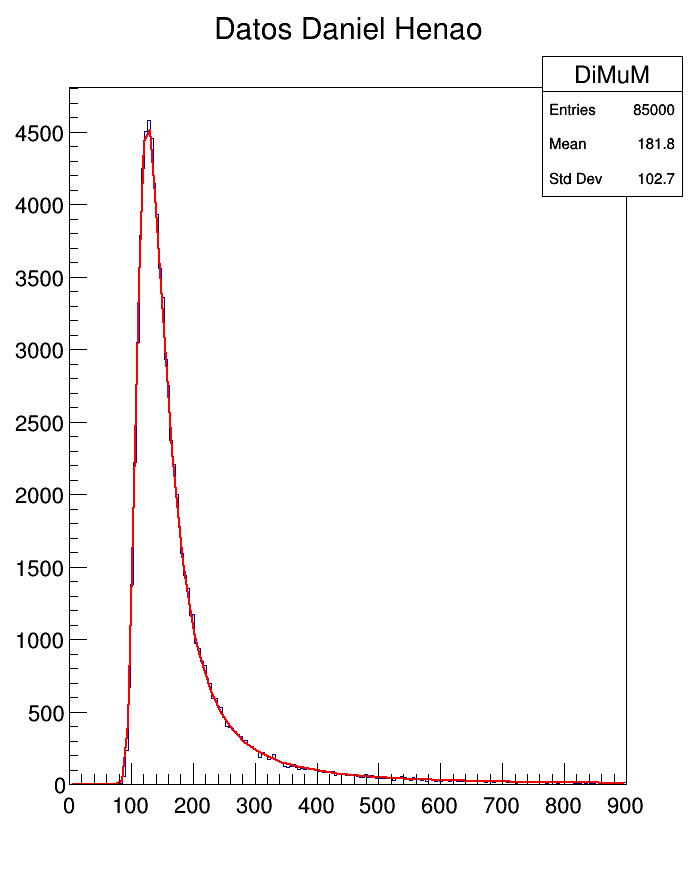

In [10]:
# Histograma y ajuste de los datos del archivo ROOT de Daniel
# Se realiza el ajuste para tener un estimado de los parametros alrededor de los cuales variar
# mientras se calcula el chi cuadrado

DiMuM = ROOT.TH1F( 'DiMuM', 'Datos Daniel Henao', 200, 0, 900 )
c1 = ROOT.TCanvas( 'c1', 'Histogram display', 100, 10, 700, 900 )

Datos = []

for entry in DataChain:
  xvalue = entry.x
  DiMuM.Fill(xvalue)
  Datos.append(xvalue)

DiMuM.Fit("landau")

c1.SetFillColor( 0 )
DiMuM.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

In [11]:
# Se hace esto para obtener las frecuencias de los histogramas

freqdatos, binsdatos = np.histogram(Datos,bins=200,range=(0,900))

In [12]:
# Funcion PDF predefinida en ROOT

def LandauPDF(x,u,c):
  LandInt = ROOT.TMath.Landau(x,u,c,True)
  return LandInt

N = integrate.quad(LandauPDF,-np.inf,np.inf,args=(130,15)) # Verificamos que la PDF esta normalizada
print(N[0])

0.9999999996923487


In [13]:
# Funcion para calcular chi cuadrado

def chi2(z_o,z_t):
    
    y = 0
    for i in range(len(z_o)):
        y += (z_o[i]-z_t[i])**2/abs(z_t[i])
    return y

# Rangos para los coeficientes u y c de la PDF de Landau
# Se refinaron cada vez mas, por eso el rango pequeño, pero al principio el rango fue mayor

u = np.arange(114,124,2)
c = np.arange(8.2,9.4,0.2)

coefs = list(itertools.product(u,c)) # Combinacion de los coeficientes

35


In [14]:
# ALGORITMO DE METROPOLIS Y CALCULO DE CHI CUADRADO PARA CADA COMBINACION DE COEFICIENTES

b = 900     # Rango del histograma
N = 85000

chi2s = []

for j in range(len(coefs)):

  x0 = b*np.random.random() # Valor inicial
  u = coefs[j][0]
  c = coefs[j][1]

  while LandauPDF(x0,u,c) == 0.: # Para evitar division por cero
    x0 = b*np.random.random()
  
  X = [x0]

  while (len(X) < N):

    xp = b*np.random.random() # Siguiente valor aleatorio

    if LandauPDF(xp,u,c) == 0.: # Para que no haya division por cero
      continue

    else:
      P = LandauPDF(xp,u,c)/LandauPDF(X[-1],u,c)

    DeltaS = -np.log(P)

    # Condiciones para aceptar o rechazar el nuevo valor aleatorio

    if (DeltaS<0):
      xi = xp
      X.append(xi)

    elif (DeltaS>0):
      r = np.random.uniform(0,1,1)
      
      if (r<P):
        xi=xp
        X.append(xi)

  # Frecuencias de las muestras generadas para una combinacion de u y c
  freqMetro, bins = np.histogram(X,bins=200,range=(0,900))

  # Se guardan los valores de chi2 para cada combinacion de u y c
  chi2s.append(chi2(freqdatos+1,freqMetro+1))  # Se corren las curvas una frecuencia hacia arriba para que no haya division por cero, 
                                               # pero esto no afecta el criterio chi2

In [15]:
c_min = chi2s.index(min(chi2s))

print("El valor minimo de chi cuadrado es",min(chi2s))
print("Los coeficientes correspondientes son",coefs[c_min])

El valor minimo de chi cuadrado es 13455.382516974822
Los coeficientes correspondientes son (118, 8.599999999999998)


In [16]:
# Se generan las muestras con los mejores coeficientes
# volviendo a usar el algoritmo de Metropolis

b = 900
N = 85000
x0 = b*np.random.random()
u = coefs[c_min][0]  #Mejores coeficientes
c = coefs[c_min][1]

while LandauPDF(x0,u,c)==0: 
  x0 = b*np.random.random()

X = [x0]

while (len(X) < N):
  xp = b*np.random.random()

  if LandauPDF(xp,u,c)==0:
    continue

  else:
    P = LandauPDF(xp,u,c)/LandauPDF(X[-1],u,c)

  DeltaS = -np.log(P)

  if (DeltaS<0):
    xi = xp
    X.append(xi)

  elif (DeltaS>0):
    r = np.random.uniform(0,1,1)
    if (r<P):
      xi=xp
      X.append(xi)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


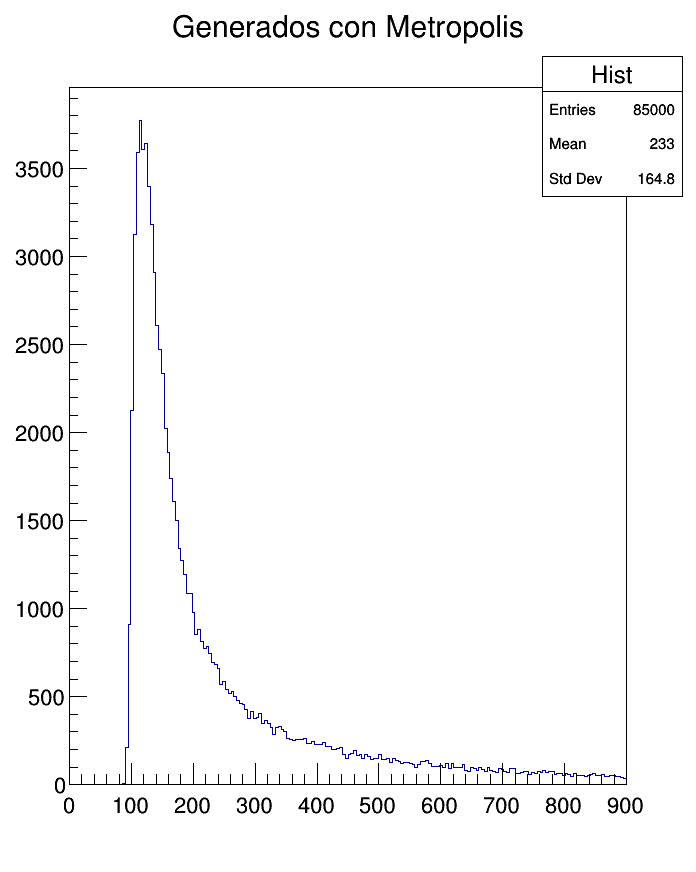

In [17]:
# Histograma con las muestras generadas con el algoritmo de Metropolis usando los mejores coeficientes (segun chi2)

Hist = ROOT.TH1F( 'Hist', 'Generados con Metropolis', 200, 0, 900 )
c1 = ROOT.TCanvas( 'c1', 'Histogram display', 100, 10, 700, 900 )

for entry in X:
  Hist.Fill(entry)

c1.SetFillColor( 0 )
Hist.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

##Datos Alexander Valencia

In [18]:
# Se carga el archivo ROOT de Alexander Valencia

DataChain2=ROOT.TChain("SystemTree")
DataChain2.Add("/content/drive/My Drive/fiscomp/AlexanderValencia.root") # Cambiar ruta de archivo

1

In [19]:
NumberOfEventsToCheck=DataChain2.GetEntries()
print("We are going to analyze ",NumberOfEventsToCheck, " events")

We are going to analyze  80000  events


 FCN=167.466 FROM MIGRAD    STATUS=CONVERGED     204 CALLS         205 TOTAL
                     EDM=1.44659e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.79641e+04   1.47654e+02   6.34232e-01  -3.61276e-06
   2  MPV          2.19998e+02   7.78668e-02   3.85953e-04  -1.77604e-03
   3  Sigma        9.99346e+00   3.97703e-02   1.88248e-06  -1.38343e+00


Warning in <TROOT::Append>: Replacing existing TH1: DiMuM (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


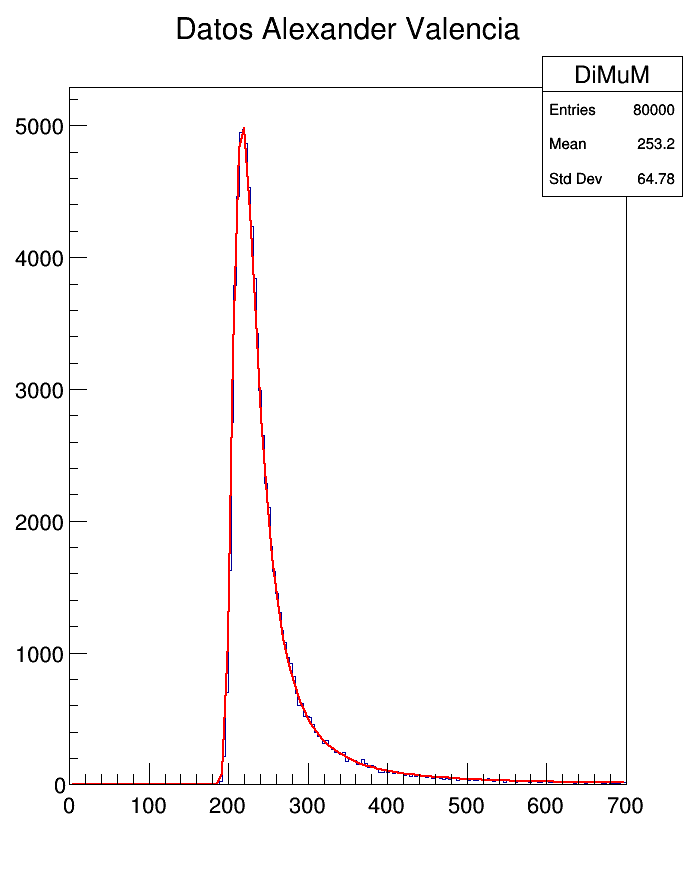

In [20]:
# Histograma y ajuste de los datos del archivo ROOT de Alexander

DiMuM = ROOT.TH1F( 'DiMuM', 'Datos Alexander Valencia', 200, 0, 700 )
c1 = ROOT.TCanvas( 'c1', 'Histogram display', 100, 10, 700, 900 )

Datos2 = []

for entry in DataChain2:
  xvalue = entry.x
  DiMuM.Fill(xvalue)
  Datos2.append(xvalue)

DiMuM.Fit("landau")

c1.SetFillColor( 0 )
DiMuM.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

In [28]:
# Se guardan las frecuencias del histograma
freqdatos2, binsdatos2 = np.histogram(Datos2,bins=200,range=(0,700))

# Rangos para los coeficientes u y c de la PDF
u2 = np.linspace(210,230,6) 
c2 = np.linspace(7,11,6) 

coefs2 = list(itertools.product(u2,c2))

36


In [29]:
# ALGORITMO DE METROPOLIS Y CALCULO DE CHI CUADRADO PARA CADA COMBINACION DE COEFICIENTES

b = 700     # Rango del histograma
N = 80000

chi2s2 = []

for j in range(len(coefs2)):

  x0 = b*np.random.random()
  u = coefs2[j][0]
  c = coefs2[j][1]

  while LandauPDF(x0,u,c)==0: # Para evitar division por cero
    x0 = b*np.random.random()

  X = [x0]

  while (len(X) < N):

    xp = b*np.random.random()

    if LandauPDF(xp,u,c)==0: # Para evitar division por cero
      continue

    else:
      P = LandauPDF(xp,u,c)/LandauPDF(X[-1],u,c)

    DeltaS = -np.log(P)

    if (DeltaS<0):
      xi = xp
      X.append(xi)

    elif (DeltaS>0):
      r = np.random.uniform(0,1,1)
      
      if (r<P):
        xi=xp
        X.append(xi)

  freqMetro2, bins2 = np.histogram(X,bins=200,range=(0,700))

  chi2s2.append(chi2(freqdatos2+1,freqMetro2+1)) 

In [30]:
c_min2 = chi2s2.index(min(chi2s2))

print("El valor minimo de chi cuadrado es",min(chi2s2))
print("Los coeficientes correspondientes son",coefs2[c_min2])

El valor minimo de chi cuadrado es 14287.1711198524
Los coeficientes correspondientes son (214.0, 7.0)
[19466.022741984772, 23763.654688584018, 26491.523680571172, 32048.421365756098, 35846.93658261665, 39832.39262928765, 14287.1711198524, 18250.377803771044, 22179.087776520868, 26657.031181746774, 31056.36835572294, 34741.91611191796, 17624.15591993556, 17263.990185685187, 20345.8506368798, 23864.24682189134, 27192.711809775366, 32181.834693836037, 145492.29088353948, 73337.2127400366, 25113.28285476195, 24600.17758710389, 27620.070591261487, 31832.57504813473, 1488234.8861456495, 365874.4589193982, 95306.2321474014, 45056.60746894262, 35973.00537139622, 34373.378454807746, 5859235.112821622, 3489459.379719238, 875826.3137911723, 381194.4420476377, 82087.87123402611, 53034.86917756205]


In [31]:
# Se generan las muestras con los mejores coeficientes

b = 700
N = 80000
x0 = b*np.random.random()
u = coefs2[c_min2][0]  #Mejores coeficientes
c = coefs2[c_min2][1]

while LandauPDF(x0,u,c)==0: 
  x0 = b*np.random.random()

X = [x0]

while (len(X) < N):
  xp = b*np.random.random()

  if LandauPDF(xp,u,c)==0:
    continue

  else:
    P = LandauPDF(xp,u,c)/LandauPDF(X[-1],u,c)

  DeltaS = -np.log(P)

  if (DeltaS<0):
    xi = xp
    X.append(xi)

  elif (DeltaS>0):
    r = np.random.uniform(0,1,1)
    if (r<P):
      xi=xp
      X.append(xi)

Warning in <TROOT::Append>: Replacing existing TH1: Hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


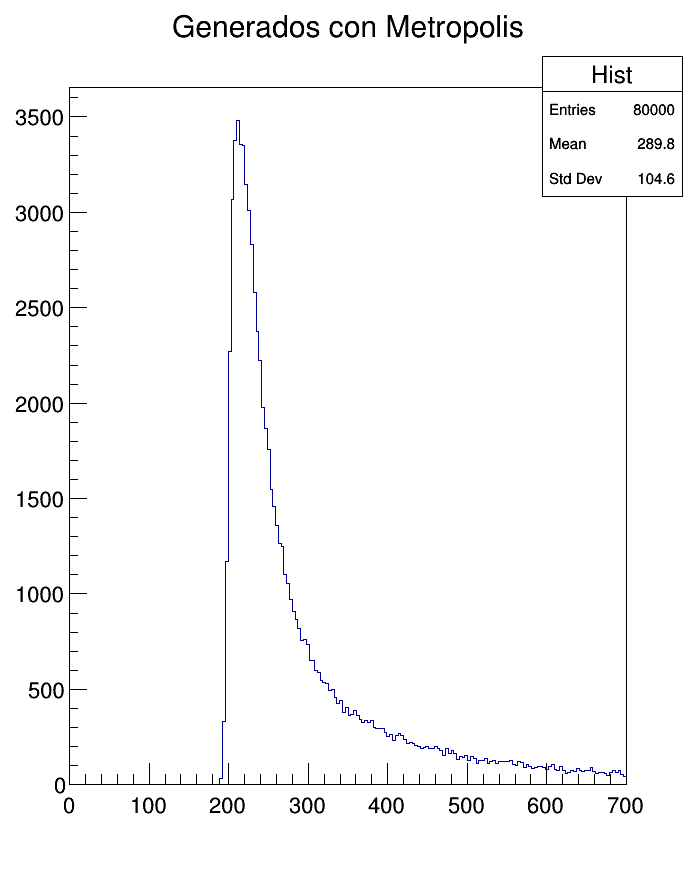

In [32]:
# Histograma con las muestras generadas con el algoritmo de Metropolis usando los mejores coeficientes (segun chi2)

Hist = ROOT.TH1F( 'Hist', 'Generados con Metropolis', 200, 0, 700 )
c1 = ROOT.TCanvas( 'c1', 'Histogram display', 100, 10, 700, 900 )

for entry in X:
  Hist.Fill(entry)

c1.SetFillColor( 0 )
Hist.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()